# Backtest: validation on historical data

<a href="https://mybinder.org/v2/gh/tinkoff-ai/etna/master?filepath=examples/backtest.ipynb">
    <img src="https://mybinder.org/badge_logo.svg"  align='left'>
</a>

This notebook contains the simple examples of time series validation using backtest module of ETNA library.

**Table of Contents**

* [What is backtest and how it works](#chapter1)  
* [How to run a validation](#chapter2)
* [Backtest with FoldMask](#chapter3)
* [Validation visualisation](#chapter4)
* [Metrics visualisation](#chapter5)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

from etna.datasets.tsdataset import TSDataset
from etna.metrics import MAE
from etna.metrics import MSE
from etna.metrics import SMAPE
from etna.pipeline import Pipeline
from etna.models import ProphetModel
from etna.analysis import plot_backtest

### 1. What is backtest and how it works <a class="anchor" id="chapter1"></a>

Backtest is a predictions and validation pipeline build on historical data to make a legitimate retrotest of your model.

<b>How does it work?</b>

When constructing a forecast using Models and further evaluating the prediction metrics, we measure the quality at one time interval, designated as test.

Backtest allows you to simulate how the model would work in the past:

* selects a period of time in the past

* builds a model using the selected interval as a training sample

* predicts the value on the test interval and calculates metrics.

The image shows a plot of the backtest pipeline with `n_folds = 3`.

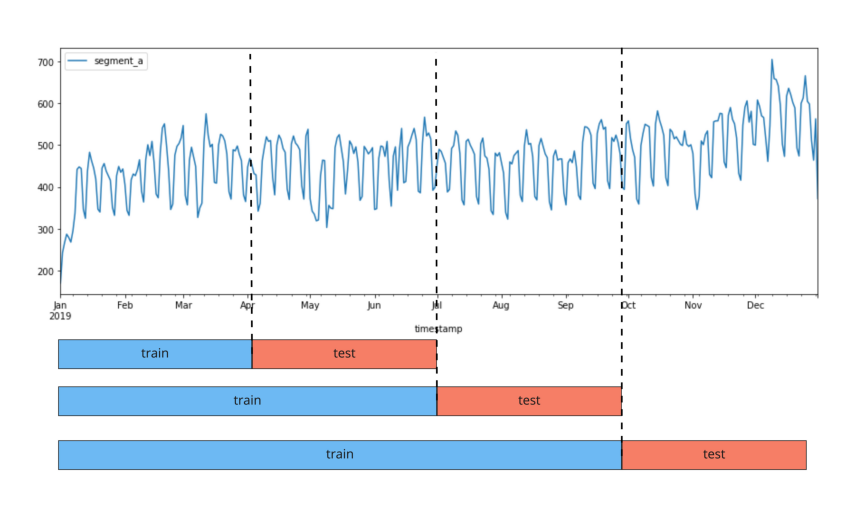

In [3]:
img = plt.imread("./assets/backtest/backtest.jpg")
plt.figure(figsize=(15, 10))
plt.axis("off")
_ = plt.imshow(img)

Below we will call a fold the train + test pair, for which training and forecasting is performed.

In [4]:
df = pd.read_csv("./data/example_dataset.csv")
df["timestamp"] = pd.to_datetime(df["timestamp"])
df = df.loc[df.segment == "segment_a"]
df.head()

,timestamp,segment,target
0,2019-01-01,segment_a,170
1,2019-01-02,segment_a,243
2,2019-01-03,segment_a,267
3,2019-01-04,segment_a,287
4,2019-01-05,segment_a,279


Our library works with the special data structure TSDataset. So, before starting the EDA, we need to convert the classical DataFrame to TSDataset.

In [5]:
df = TSDataset.to_dataset(df)
ts = TSDataset(df, freq="D")

#### Let's get a look on series

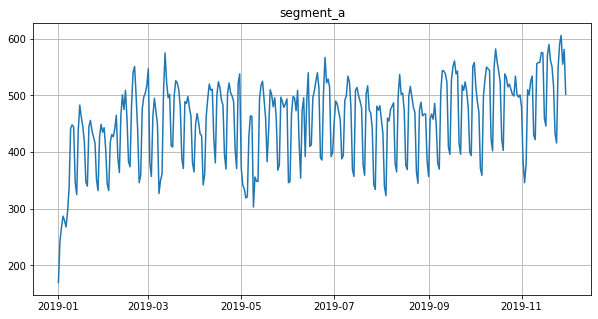

In [6]:
ts.plot(segments=["segment_a"])

### 2. How to run a validation <a class="anchor" id="chapter2"></a>

For an easy start let's create a Prophet model

In [7]:
horizon = 31  # Set the horizon for predictions
model = ProphetModel()  # Create a model
transforms = []  # A list of transforms -  we will not use any of them

### `Pipeline` <a class="anchor" id="section_2_1"></a>

Now let's create an instance of `Pipeline`.

In [8]:
pipeline = Pipeline(model=model, transforms=transforms, horizon=horizon)

We are going to run `backtest` method for it. As a result, three dataframes will be returned: 
* dataframe with metrics for each fold and each segment, 
* dataframe with predictions, 
* dataframe with information about folds.

In [9]:
metrics_df, forecast_df, fold_info_df = pipeline.backtest(ts=ts, metrics=[MAE(), MSE(), SMAPE()])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
14:35:10 - cmdstanpy - INFO - Chain [1] start processing
14:35:10 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
14:35:11 - cmdstanpy - INFO - Chain [1] start processing
14:35:11 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.1s remaining:    0.0s
14:35:12 - cmdstanpy - INFO - Chain [1] start processing
14:35:12 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.0s remaining:    0.0s
14:35:13 - cmdstanpy - INFO - Chain [1] start processing
14:35:13 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    4.1s remaining:    0.0s
14:35:14 - cmdstanpy - INFO - Chain [1] start processing
14:35:14 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   5 out

In [10]:
metrics_df.head()

,segment,MAE,MSE,SMAPE,fold_number
0,segment_a,18.851344,595.763719,4.372066,0
0,segment_a,21.026910,673.249070,4.842875,1
0,segment_a,30.107632,1315.679297,6.302994,2
0,segment_a,36.204963,2021.144120,7.470983,3
0,segment_a,32.003925,1872.618930,6.470948,4


In [11]:
forecast_df.head()

segment      segment_a            
feature    fold_number      target
timestamp                         
2019-06-29           0  395.286255
2019-06-30           0  386.204016
2019-07-01           0  493.164874
2019-07-02           0  509.586239
2019-07-03           0  497.749328

In [12]:
fold_info_df.head()

,train_start_time,train_end_time,test_start_time,test_end_time,fold_number
0,2019-01-01,2019-06-28,2019-06-29,2019-07-29,0
0,2019-01-01,2019-07-29,2019-07-30,2019-08-29,1
0,2019-01-01,2019-08-29,2019-08-30,2019-09-29,2
0,2019-01-01,2019-09-29,2019-09-30,2019-10-30,3
0,2019-01-01,2019-10-30,2019-10-31,2019-11-30,4


You can additionally get the metrics averaged over folds:

In [13]:
metrics_df, forecast_df, fold_info_df = pipeline.backtest(
    ts=ts, metrics=[MAE(), MSE(), SMAPE()], aggregate_metrics=True
)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
14:35:20 - cmdstanpy - INFO - Chain [1] start processing
14:35:20 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
14:35:21 - cmdstanpy - INFO - Chain [1] start processing
14:35:21 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.9s remaining:    0.0s
14:35:22 - cmdstanpy - INFO - Chain [1] start processing
14:35:22 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.9s remaining:    0.0s
14:35:23 - cmdstanpy - INFO - Chain [1] start processing
14:35:23 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    4.0s remaining:    0.0s
14:35:24 - cmdstanpy - INFO - Chain [1] start processing
14:35:24 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   5 out

In [14]:
metrics_df.head()

,segment,MAE,MSE,SMAPE
0,segment_a,27.638955,1295.691027,5.891973


In [15]:
forecast_df.head()

segment      segment_a            
feature    fold_number      target
timestamp                         
2019-06-29           0  395.286255
2019-06-30           0  386.204016
2019-07-01           0  493.164874
2019-07-02           0  509.586239
2019-07-03           0  497.749328

In [16]:
fold_info_df.head()

,train_start_time,train_end_time,test_start_time,test_end_time,fold_number
0,2019-01-01,2019-06-28,2019-06-29,2019-07-29,0
0,2019-01-01,2019-07-29,2019-07-30,2019-08-29,1
0,2019-01-01,2019-08-29,2019-08-30,2019-09-29,2
0,2019-01-01,2019-09-29,2019-09-30,2019-10-30,3
0,2019-01-01,2019-10-30,2019-10-31,2019-11-30,4


### 3. Backtest with fold masks<a class="anchor" id="chapter3"></a>

You can use your backtest strategies using `FoldMask`. In order to make a `FoldMask`, you need to specify `first_train_timestamp`, `last_train_timestamp`, `target_timestamps`. Then you need to pass a list of masks as the `n_folds` parameter to the `pipeline.backtest`.

Consider 3 strategies similar to `SlidingWindowSplitter`, `ExpandingWindowSplitter` and `SingleWindowSplitter` from `sktime`.

#### `ExpandingWindowSplitter` 

For this backtest strategy you can use our backtest with `mode="expand"`.

In [17]:
metrics_df, _, _ = pipeline.backtest(ts=ts, metrics=[MAE(), MSE(), SMAPE()], n_folds=3, mode="expand")

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
14:35:30 - cmdstanpy - INFO - Chain [1] start processing
14:35:30 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
14:35:31 - cmdstanpy - INFO - Chain [1] start processing
14:35:31 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.0s remaining:    0.0s
14:35:32 - cmdstanpy - INFO - Chain [1] start processing
14:35:32 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.0s finished


In [18]:
metrics_df

,segment,MAE,MSE,SMAPE,fold_number
0,segment_a,30.107632,1315.679297,6.302994,0
0,segment_a,36.204963,2021.144120,7.470983,1
0,segment_a,32.003925,1872.618930,6.470948,2


#### `SingleWindowSplitter`

For this backtest strategy you can use our backtest with parameter `n_folds=1` or if you need specific window from your dataset you can create a mask with `FoldMask`.

In [19]:
from etna.pipeline import FoldMask
import numpy as np

In [20]:
# 1 Without mask

metrics_df, _, _ = pipeline.backtest(ts=ts, metrics=[MAE(), MSE(), SMAPE()], n_folds=1)
metrics_df

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
14:35:33 - cmdstanpy - INFO - Chain [1] start processing
14:35:33 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished


,segment,MAE,MSE,SMAPE,fold_number
0,segment_a,32.003925,1872.61893,6.470948,0


In [21]:
# 2 With specific mask
window_size = 85
first_train_timestamp = ts.index.min() + np.timedelta64(100, "D")
last_train_timestamp = first_train_timestamp + np.timedelta64(window_size, "D")
target_timestamps = pd.date_range(start=last_train_timestamp + np.timedelta64(1, "D"), periods=horizon)
mask = FoldMask(
    first_train_timestamp=first_train_timestamp,
    last_train_timestamp=last_train_timestamp,
    target_timestamps=target_timestamps,
)

In [22]:
# 1 Without mask

metrics_df, _, _ = pipeline.backtest(ts=ts, metrics=[MAE(), MSE(), SMAPE()], n_folds=[mask])
metrics_df

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
14:35:34 - cmdstanpy - INFO - Chain [1] start processing
14:35:35 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished


,segment,MAE,MSE,SMAPE,fold_number
0,segment_a,39.782294,2191.914485,9.056343,0


#### `SlidingWindowSplitter`

To implement this backtest strategy you need to create a list of fold masks with `FoldMask`.

In [23]:
n_folds = 3

In [24]:
def sliding_window_masks(window_size, n_folds):
    masks = []
    for n in range(n_folds):
        first_train_timestamp = ts.index.min() + np.timedelta64(100, "D") + np.timedelta64(n, "D")
        last_train_timestamp = first_train_timestamp + np.timedelta64(window_size, "D")
        target_timestamps = pd.date_range(start=last_train_timestamp + np.timedelta64(1, "D"), periods=horizon)
        mask = FoldMask(
            first_train_timestamp=first_train_timestamp,
            last_train_timestamp=last_train_timestamp,
            target_timestamps=target_timestamps,
        )
        masks.append(mask)
    return masks

In [25]:
masks = sliding_window_masks(window_size=window_size, n_folds=n_folds)
metrics_df, _, _ = pipeline.backtest(ts=ts, metrics=[MAE(), MSE(), SMAPE()], n_folds=masks)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
14:35:36 - cmdstanpy - INFO - Chain [1] start processing
14:35:36 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s
14:35:37 - cmdstanpy - INFO - Chain [1] start processing
14:35:37 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.4s remaining:    0.0s
14:35:38 - cmdstanpy - INFO - Chain [1] start processing
14:35:38 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.6s finished


In [26]:
metrics_df

,segment,MAE,MSE,SMAPE,fold_number
0,segment_a,39.782294,2191.914485,9.056343,0
0,segment_a,40.293273,2287.327210,9.108208,1
0,segment_a,39.861473,2192.540812,9.010115,2


### 4. Validation visualisation <a class="anchor" id="chapter4"></a>

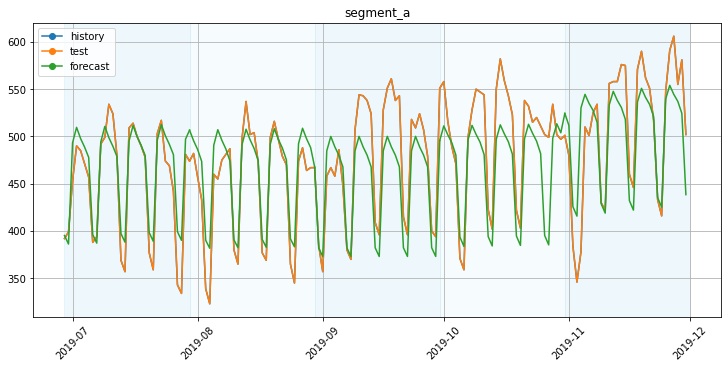

In [27]:
plot_backtest(forecast_df, ts)

To visualize the train part, you can specify the `history_len` parameter. 

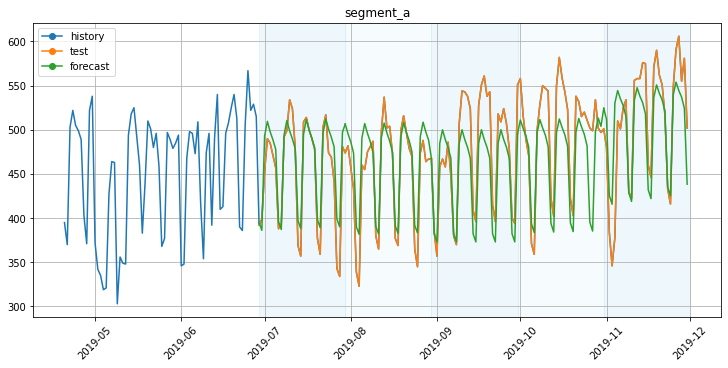

In [28]:
plot_backtest(forecast_df, ts, history_len=70)

### 5. Metrics visualization  <a class="anchor" id="chapter5"></a>

In this section we will analyze the backtest results from the different point of views. 

In [29]:
from etna.analysis import (
    metric_per_segment_distribution_plot,
    plot_residuals,
    plot_metric_per_segment,
    prediction_actual_scatter_plot,
)

In [30]:
df = pd.read_csv("./data/example_dataset.csv")
df["timestamp"] = pd.to_datetime(df["timestamp"])
df = TSDataset.to_dataset(df)
ts_all = TSDataset(df, freq="D")

In [31]:
metrics_df, forecast_df, fold_info_df = pipeline.backtest(ts=ts_all, metrics=[MAE(), MSE(), SMAPE()])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
14:35:42 - cmdstanpy - INFO - Chain [1] start processing
14:35:42 - cmdstanpy - INFO - Chain [1] done processing
14:35:42 - cmdstanpy - INFO - Chain [1] start processing
14:35:42 - cmdstanpy - INFO - Chain [1] done processing
14:35:42 - cmdstanpy - INFO - Chain [1] start processing
14:35:42 - cmdstanpy - INFO - Chain [1] done processing
14:35:42 - cmdstanpy - INFO - Chain [1] start processing
14:35:42 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.8s remaining:    0.0s
14:35:46 - cmdstanpy - INFO - Chain [1] start processing
14:35:46 - cmdstanpy - INFO - Chain [1] done processing
14:35:46 - cmdstanpy - INFO - Chain [1] start processing
14:35:46 - cmdstanpy - INFO - Chain [1] done processing
14:35:46 - cmdstanpy - INFO - Chain [1] start processing
14:35:46 - cmdstanpy - INFO - Chain [1] done processing
14:35:46 - cmdstanpy - INFO - Chain [1] start pr

Let's look at the distribution of the SMAPE metric by folds. You can set `type_plot` as `box`, `violin` or `hist`.

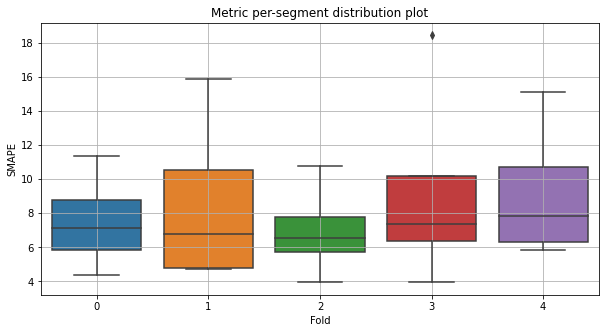

In [32]:
metric_per_segment_distribution_plot(metrics_df=metrics_df, metric_name="SMAPE", plot_type="box")

Let's look at the SMAPE metric by segments

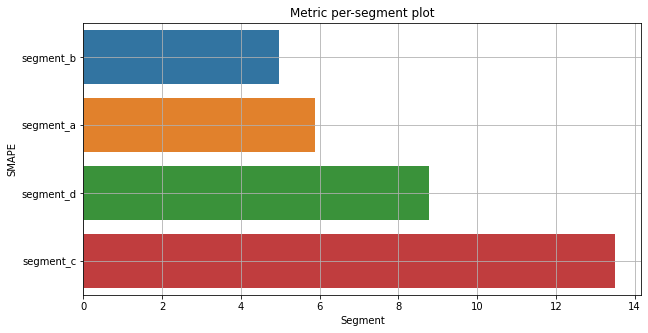

In [33]:
plot_metric_per_segment(metrics_df=metrics_df, metric_name="SMAPE", ascending=True)

Now let's look at the residuals of the model predictions from the backtest. Analysis of the residuals can help establish a dependency in the data that our model was not able to find. This way we can add features or improve the model or make sure that there is no dependency in the residuals. Also, you can visualize the residuals not only by timestamp but by any feature.

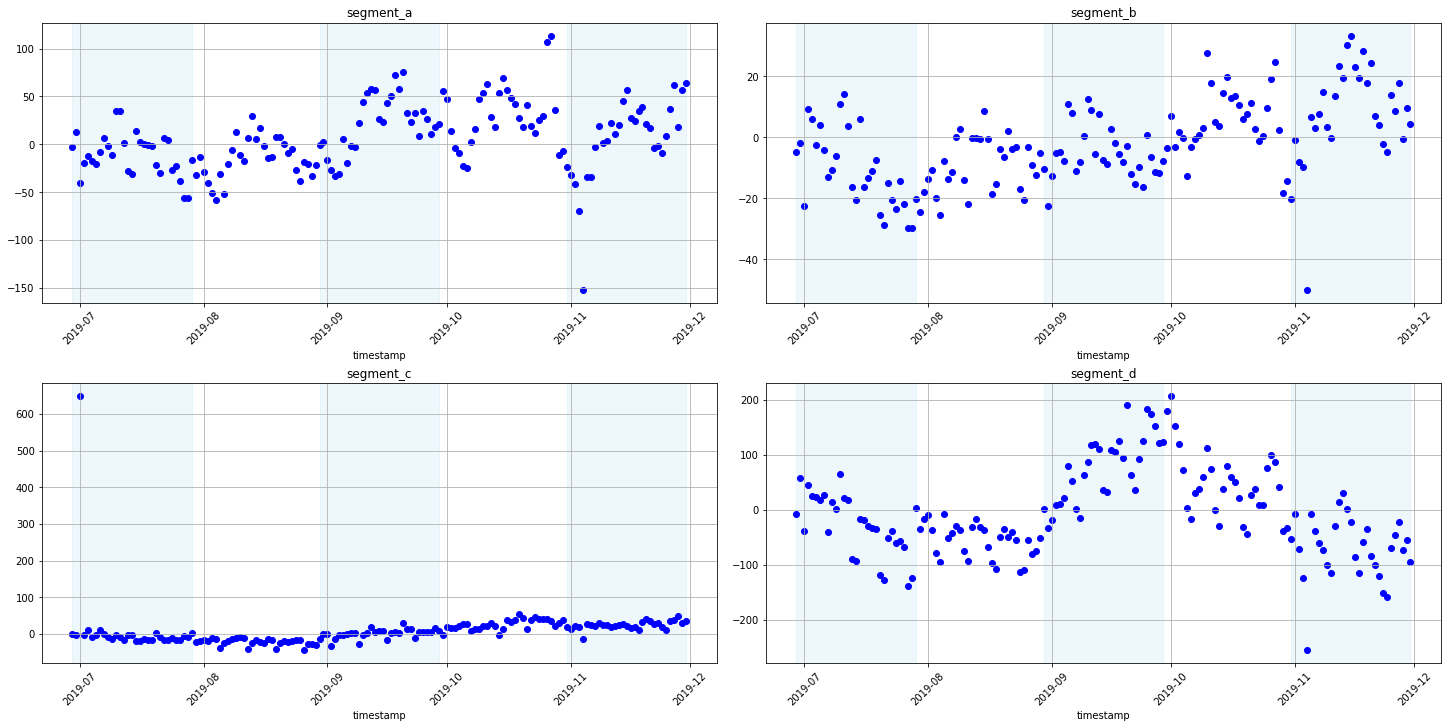

In [34]:
plot_residuals(forecast_df=forecast_df, ts=ts_all)

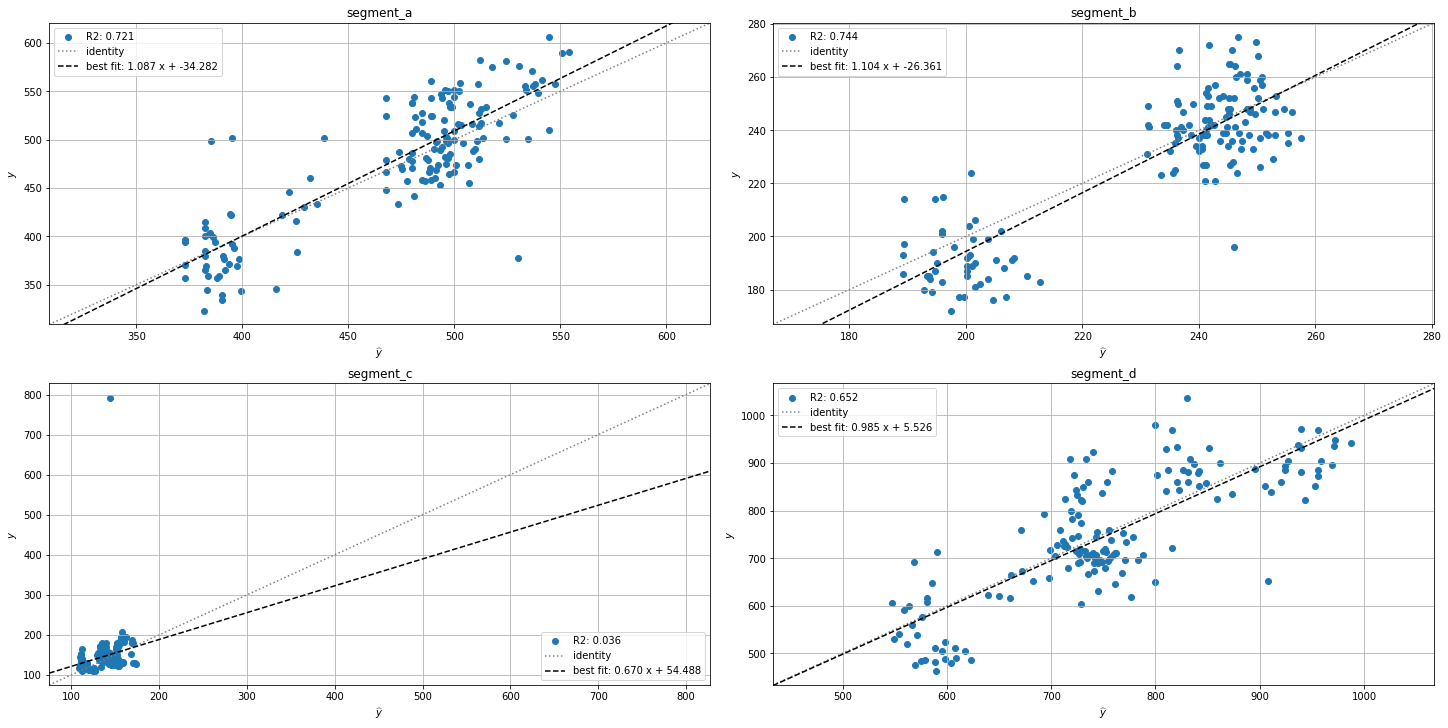

In [35]:
prediction_actual_scatter_plot(forecast_df=forecast_df, ts=ts_all)

That's all for this notebook. More features you can find in our documentation!